**Authorized to access Google Drive**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/Colab Notebooks/MSc_project/dataset/train/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import libraries**

In [0]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from tqdm import tqdm_notebook, tnrange
import sys
import os
print(os.listdir(path))

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from keras import metrics
from keras.utils import np_utils, plot_model
from keras.models import Model, load_model
from keras.layers import Input, concatenate, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
from keras.layers.core import Lambda, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# np.set_printoptions(threshold=np.inf)

['masks', 'images']


Using TensorFlow backend.


**Visualizing examples image and masks of training set**

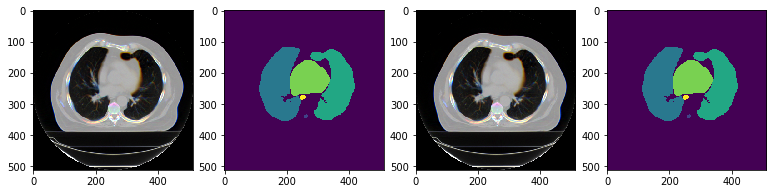

In [0]:
plt.figure(figsize=(20,10))
for j in range(2):
    q = j+1
    j = j+1
    img = np.load(path+'images/' + str(45) + '_image.npy').transpose(1, 2, 0)
    img_mask = np.load(path+'masks/' + str(45) +'_mask.npy')
    
    plt.subplot(1,2*3,q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*3,q*2)
    plt.imshow(img_mask)
plt.show()

**Matching images and masks when training**

In [0]:
import re
train_ids = next(os.walk(path+"images"))[2]
print(len(train_ids))
new_train_ids=[]
for item in train_ids:
    new_train_ids.append(' '.join(re.findall(r'\d+', item)))
print(new_train_ids)

108
['62', '87', '18', '43', '76', '39', '34', '15', '104', '7', '57', '20', '81', '45', '93', '51', '48', '70', '32', '98', '1', '64', '95', '26', '102', '42', '69', '63', '108', '77', '13', '6', '19', '38', '14', '56', '105', '21', '71', '94', '99', '92', '50', '35', '86', '27', '33', '44', '65', '80', '49', '12', '60', '85', '103', '5', '68', '55', '41', '88', '36', '22', '74', '8', '91', '58', '3', '29', '106', '17', '79', '72', '66', '100', '11', '53', '47', '30', '83', '75', '23', '4', '24', '97', '54', '9', '90', '40', '89', '61', '59', '84', '107', '28', '46', '16', '67', '73', '37', '2', '78', '101', '10', '96', '25', '31', '52', '82']


**Set the input shape**

In [0]:
input_shape=(512, 512, 3)
im_width = input_shape[0]
im_height = input_shape[1]
n_labels = 6

**Resize images and masks into tensor**

In [0]:
X_train = np.zeros((len(new_train_ids), im_height, im_width, 3), dtype=np.uint8)
Y_train = np.zeros((len(new_train_ids), im_height, im_width), dtype=np.uint8)
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(new_train_ids), total=len(new_train_ids)):
    img = np.load(path + 'images/' + id_+'_image.npy').transpose(1, 2, 0)
    x = img[:,:,:]
    x = resize(x, (512, 512, 3), mode='constant', preserve_range=True)
    X_train[n] = x
    
    mask = (np.load(path + 'masks/' + id_+'_mask.npy'))
    Y_train[n] = resize(mask, (512, 512), mode='constant', preserve_range=True)

print(Y_train.shape)
#np_utils.to_categorical for one hot encoding to no of label 
Y_train = np_utils.to_categorical(Y_train, n_labels)
print(X_train.shape)
print(Y_train.shape)


(108, 512, 512)
(108, 512, 512, 3)
(108, 512, 512, 6)


**Use MIoU as evalutaion metrics**

In [0]:
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

**Build U-Net model using Keras**

In [0]:
inputs = Input((input_shape))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2),kernel_initializer='he_normal', padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2),kernel_initializer='he_normal', padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2),kernel_initializer='he_normal', padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2),kernel_initializer='he_normal', padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(n_labels, (1, 1), activation='softmax') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='categorical_crossentropy' , metrics=['categorical_accuracy', iou_coef])
model.summary()

W0903 20:28:50.081312 139884693493632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0903 20:28:50.095030 139884693493632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0903 20:28:50.101962 139884693493632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4479: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0903 20:28:50.124678 139884693493632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0903 20:28:50.360873 139884693493632 deprec

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 8)  224         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 8)  584         conv2d_1[0][0]                   
____________________________________________________________________________________________

In [0]:
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/MSc_project/test/model.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.3, batch_size=32, epochs=100, 
                    callbacks=[earlystopper, checkpointer])

model.save('/content/drive/My Drive/Colab Notebooks/MSc_project/test/model.h5')

W0903 20:28:55.267426 139884693493632 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 75 samples, validate on 33 samples
Epoch 1/100
75/75 [==============================] - 19s 251ms/step - loss: 1.8035 - categorical_accuracy: 0.4768 - iou_coef: 0.1628 - val_loss: 1.4707 - val_categorical_accuracy: 0.7190 - val_iou_coef: 0.1445

Epoch 00001: val_loss improved from inf to 1.47067, saving model to /content/drive/My Drive/Colab Notebooks/MSc_project/test/model.h5
Epoch 2/100
75/75 [==============================] - 3s 35ms/step - loss: 1.4339 - categorical_accuracy: 0.7469 - iou_coef: 0.1527 - val_loss: 1.2594 - val_categorical_accuracy: 0.7716 - val_iou_coef: 0.2800

Epoch 00002: val_loss improved from 1.47067 to 1.25941, saving model to /content/drive/My Drive/Colab Notebooks/MSc_project/test/model.h5
Epoch 3/100
75/75 [==============================] - 3s 35ms/step - loss: 1.1885 - categorical_accuracy: 0.7895 - iou_coef: 0.2953 - val_loss: 0.9499 - val_categorical_accuracy: 0.8402 - val_iou_coef: 0.3318

Epoch 00003: val_loss improved from 1.25941 to 0.94990,

**Visualization**

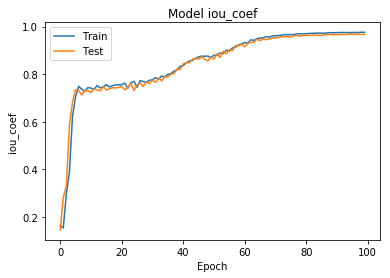

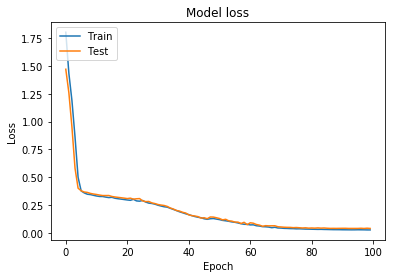

In [0]:
# Draw MIoU
plt.plot(results.history['iou_coef'])
plt.plot(results.history['val_iou_coef'])
plt.title('Model iou_coef')
plt.ylabel('iou_coef')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Draw Loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()